## Connecting to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change to the path pointing the this shared folder in your drive
%cd /content/drive/MyDrive/HW3_DL

/content/drive/MyDrive/HW3_DL


## Libraries

In [ ]:
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

import imageio
import numpy as np
from torchvision.utils import make_grid
from torch.autograd import grad as torch_grad

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Functions

In [ ]:
class Generator_GP(nn.Module):
    def __init__(self, img_size, latent_dim, dim):
        super(Generator_GP, self).__init__()

        self.dim = dim
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.feature_sizes = (int(self.img_size[0] / 16), int(self.img_size[1] / 16))
        self.latent_to_features = nn.Sequential(
            nn.Linear(latent_dim, 8 * dim * self.feature_sizes[0] * self.feature_sizes[1]),
            nn.ReLU()
        )

        self.features_to_image = nn.Sequential(
            nn.ConvTranspose2d(8 * dim, 4 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(4 * dim),
            nn.ConvTranspose2d(4 * dim, 2 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(2 * dim),
            nn.ConvTranspose2d(2 * dim, dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(dim),
            nn.ConvTranspose2d(dim, self.img_size[2], 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        # Map latent into appropriate size for transposed convolutions
        x = self.latent_to_features(input_data)
        # Reshape
        x = x.view(-1, 8 * self.dim, self.feature_sizes[0], self.feature_sizes[1])
        # Return generated image
        return self.features_to_image(x)

    def sample_latent(self, num_samples):
        return torch.randn((num_samples, self.latent_dim))


class Discriminator_GP(nn.Module):
    def __init__(self, img_size, dim):
        """
        img_size : (int, int, int)
            Height and width must be powers of 2.  E.g. (32, 32, 1) or
            (64, 128, 3). Last number indicates number of channels, e.g. 1 for
            grayscale or 3 for RGB
        """
        super(Discriminator_GP, self).__init__()

        self.img_size = img_size

        self.image_to_features = nn.Sequential(
            nn.Conv2d(self.img_size[2], dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim, 2 * dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(2 * dim, 4 * dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(4 * dim, 8 * dim, 4, 2, 1),
            nn.Sigmoid()
        )

        # 4 convolutions of stride 2, i.e. halving of size everytime
        # So output size will be 8 * (img_size / 2 ^ 4) * (img_size / 2 ^ 4)
        output_size = 8 * dim * (int(img_size[0] / 16)) * (int(img_size[1] / 16))
        self.features_to_prob = nn.Sequential(
            nn.Linear(output_size, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        batch_size = int(input_data.size()[0])
        x = self.image_to_features(input_data)
        x = x.view(batch_size, -1)
        return self.features_to_prob(x)

In [ ]:
class Trainer_GP():
    def __init__(self, generator, discriminator, gen_optimizer, dis_optimizer,
                 gp_weight=10, critic_iterations=5, print_every=50,
                 use_cuda=False):
        self.G = generator
        self.G_opt = gen_optimizer
        self.D = discriminator
        self.D_opt = dis_optimizer
        self.losses = {'G': [], 'D': [], 'GP': [], 'gradient_norm': []}
        self.num_steps = 0
        self.use_cuda = use_cuda
        self.gp_weight = gp_weight
        self.critic_iterations = critic_iterations
        self.print_every = print_every

        if self.use_cuda:
            self.G.cuda()
            self.D.cuda()

    def _critic_train_iteration(self, data):
        """ """
        # Get generated data
        batch_size = data.size()[0]
        generated_data = self.sample_generator(batch_size)

        # Calculate probabilities on real and generated data
        data = Variable(data)
        if self.use_cuda:
            data = data.cuda()
        d_real = self.D(data)
        d_generated = self.D(generated_data)

        # Get gradient penalty
        gradient_penalty = self._gradient_penalty(data, generated_data)
        self.losses['GP'].append(gradient_penalty.item())

        # Create total loss and optimize
        self.D_opt.zero_grad()
        d_loss = d_generated.mean() - d_real.mean() + gradient_penalty
        d_loss.backward()

        self.D_opt.step()

        # Record loss
        self.losses['D'].append(d_loss.data.item())

    def _generator_train_iteration(self, data):
        """ """
        self.G_opt.zero_grad()

        # Get generated data
        batch_size = data.size()[0]
        generated_data = self.sample_generator(batch_size)

        # Calculate loss and optimize
        d_generated = self.D(generated_data)
        g_loss = - d_generated.mean()
        g_loss.backward()
        self.G_opt.step()

        # Record loss
        self.losses['G'].append(g_loss.data.item())

    def _gradient_penalty(self, real_data, generated_data):
        batch_size = real_data.size()[0]

        # Calculate interpolation
        alpha = torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        if self.use_cuda:
            alpha = alpha.cuda()
        interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
        interpolated = Variable(interpolated, requires_grad=True)
        if self.use_cuda:
            interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        prob_interpolated = self.D(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if self.use_cuda else torch.ones(
                               prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)
        self.losses['gradient_norm'].append(gradients.norm(2, dim=1).mean().data.item())

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return self.gp_weight * ((gradients_norm - 1) ** 2).mean()

    def _train_epoch(self, data_loader):
        for i, data in enumerate(data_loader):
            self.num_steps += 1
            self._critic_train_iteration(data[0])
            # Only update generator every |critic_iterations| iterations
            if self.num_steps % self.critic_iterations == 0:
                self._generator_train_iteration(data[0])

            if i % self.print_every == 0:
                print("Iteration {}".format(i + 1))
                print("D: {}".format(self.losses['D'][-1]))
                print("GP: {}".format(self.losses['GP'][-1]))
                print("Gradient norm: {}".format(self.losses['gradient_norm'][-1]))
                if self.num_steps > self.critic_iterations:
                    print("G: {}".format(self.losses['G'][-1]))

    def train(self, data_loader, epochs, save_training_gif=True):
        if save_training_gif:
            # Fix latents to see how image generation improves during training
            fixed_latents = Variable(self.G.sample_latent(64))
            if self.use_cuda:
                fixed_latents = fixed_latents.cuda()
            training_progress_images = []

        for epoch in range(epochs):
            print("\nEpoch {}".format(epoch + 1))
            self._train_epoch(data_loader)

            if save_training_gif:
                # Generate batch of images and convert to grid
                img_grid = make_grid(self.G(fixed_latents).cpu().data)
                # Convert to numpy and transpose axes to fit imageio convention
                # i.e. (width, height, channels)
                img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))
                # Add image grid to training progress
                training_progress_images.append(img_grid)

        if save_training_gif:
            imageio.mimsave('./wp_gan_training_{}_epochs.gif'.format(epochs),
                            training_progress_images)

        return self.losses, training_progress_images

    def sample_generator(self, num_samples):
        latent_samples = Variable(self.G.sample_latent(num_samples))
        if self.use_cuda:
            latent_samples = latent_samples.cuda()
        generated_data = self.G(latent_samples)
        return generated_data

    def sample(self, num_samples):
        generated_data = self.sample_generator(num_samples)
        # Remove color channel
        return generated_data.data.cpu().numpy()[:, 0, :, :]

In [ ]:
def generate_im_batch_gp(model):
  fixed_latents = Variable(model.sample_latent(64))
  img_grid = make_grid(model(fixed_latents).cpu().data)
  img_grid = np.transpose(img_grid.numpy(), (1, 2, 0))
  plt.figure(figsize = (10,10))
  plt.imshow(img_grid)

## WGAN model

In [ ]:
def run_wgp():

  """Fashion MNIST dataloader with (32, 32) sized images."""
  # Resize images so they are a power of 2
  batch_size = 64
  all_transforms = transforms.Compose([
      transforms.Resize(64), # was 32
      transforms.ToTensor()
  ])
  # Get train and test data
  train_data = datasets.FashionMNIST('../fashion_data', train=True, download=True,
                                       transform=all_transforms)
  test_data = datasets.FashionMNIST('../fashion_data', train=False,
                                      transform=all_transforms)
  # Create dataloaders
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

  data_loader =  train_loader
  img_size = (64, 64, 1) # was (32, 32, 1)

  generator = Generator_GP(img_size=img_size, latent_dim=100, dim=16)
  discriminator = Discriminator_GP(img_size=img_size, dim=16)

  print(generator)
  print(discriminator)

  # Initialize optimizers
  lr = 1e-4
  betas = (.9, .99)
  G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=betas)
  D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

  # Train model
  epochs = 200
  trainer = Trainer_GP(generator, discriminator, G_optimizer, D_optimizer,
                  use_cuda=torch.cuda.is_available())
  losses, train_prog_ims = trainer.train(data_loader, epochs, save_training_gif=True)

  # Save models
  name = 'fashion_mnist_model'
  torch.save(trainer.G.state_dict(), './wp_gen_' + name + '.pt')
  torch.save(trainer.D.state_dict(), './wp_dis_' + name + '.pt')
  plt.plot(losses['D'])
  plt.plot(losses['G'])

## DCGAN model

In [ ]:
def normal_init(m):
  if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    m.weight.data.normal_(0.0, 0.02)
    m.bias.data.zero_()

In [ ]:
class discriminator_DC(nn.Module):

  def __init__(self):
    super(discriminator_DC, self).__init__()
    self.conv1 = nn.Conv2d(1, 128, 4, 2, 1)
    self.conv2 = nn.Conv2d(128, 256, 4, 2, 1)
    self.conv2_bn = nn.BatchNorm2d(256)
    self.conv3 = nn.Conv2d(256, 512, 4, 2, 1)
    self.conv3_bn = nn.BatchNorm2d(512)
    self.conv4 = nn.Conv2d(512, 1024, 4, 2, 1)
    self.conv4_bn = nn.BatchNorm2d(1024)
    self.conv5 = nn.Conv2d(1024, 1, 4, 1, 0)

  def weight_init(self):
    for m in self._modules:
      normal_init(self._modules[m])

  def forward(self, input):
    x = F.leaky_relu(self.conv1(input), 0.2)
    x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
    x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
    x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
    x = F.sigmoid(self.conv5(x))
    # x = self.conv5(x)
    return x

class generator_DC(nn.Module):

  def __init__(self):
    super(generator_DC, self).__init__()
    self.deconv1 = nn.ConvTranspose2d(100, 1024, 4, 1, 0)
    self.deconv1_bn = nn.BatchNorm2d(1024)
    self.deconv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
    self.deconv2_bn = nn.BatchNorm2d(512)
    self.deconv3 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
    self.deconv3_bn = nn.BatchNorm2d(256)
    self.deconv4 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
    self.deconv4_bn = nn.BatchNorm2d(128)
    self.deconv5 = nn.ConvTranspose2d(128, 1, 4, 2, 1)

  def weight_init(self):
    for m in self._modules:
      normal_init(self._modules[m])

  def forward(self, input):
    x = F.relu(self.deconv1_bn(self.deconv1(input)))
    x = F.relu(self.deconv2_bn(self.deconv2(x)))
    x = F.relu(self.deconv3_bn(self.deconv3(x)))
    x = F.relu(self.deconv4_bn(self.deconv4(x)))
    x = F.tanh(self.deconv5(x))
    #x = self.deconv5(x)
    return x

In [ ]:
def run_dc():

  img_size = 64
  n_epochs = 15
  batch_size = 64
  learning_rate = 0.0002

  transform = transforms.Compose([
      transforms.Resize(img_size),
      transforms.ToTensor(),
  ])

  train_loader = torch.utils.data.DataLoader(
      dset.FashionMNIST('fashion', train = True,
                        download = True, transform = transform),
      batch_size = batch_size,
      shuffle = True
  )

  def plot_output():
    z_ = torch.randn((5*5, 100)).view(-1, 100, 1, 1)
    z_ = Variable(z_.cuda(), volatile = True)

    generator.eval()
    test_images = generator(z_)
    generator.train()

    grid_size = 5
    fig, ax = plt.subplots(grid_size, grid_size, figsize = (5, 5))
    for i, j in itertools.product(range(grid_size), range(grid_size)):
      ax[i, j].get_xaxis().set_visible(False)
      ax[i, j].get_yaxis().set_visible(False)
    for k in range(grid_size * grid_size):
      i = k // grid_size
      j = k % grid_size
      ax[i, j].cla()
      ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(),
                    cmap = 'gray')

    plt.show()

  generator = generator_DC()
  discriminator = discriminator_DC()
  generator.weight_init()
  discriminator.weight_init()
  generator.cuda()
  discriminator.cuda()

  BCE_loss = nn.BCELoss() # nn.BCEWithLogitsLoss

  beta_1 = 0.5
  beta_2 = 0.999

  G_optimizer = optim.Adam(generator.parameters(),
                         lr = learning_rate,
                         betas = (beta_1, beta_2))

  D_optimizer = optim.Adam(discriminator.parameters(),
                         lr = learning_rate / 4,
                         betas = (beta_1, beta_2))

  for epoch in range(n_epochs):

    D_losses = []
    G_losses = []

    for X, _ in train_loader:
      discriminator.zero_grad()
      mini_batch = X.size()[0]

      y_real_ = torch.ones(mini_batch)
      y_fake_ = torch.zeros(mini_batch)

      X = Variable(X.cuda())
      y_real_ = Variable(y_real_.cuda())
      y_fake_ = Variable(y_fake_.cuda())

      D_result = discriminator(X).squeeze()
      D_real_loss = BCE_loss(D_result, y_real_)

      z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
      z_ = Variable(z_.cuda())
      G_result = generator(z_)

      D_result = discriminator(G_result).squeeze()
      D_fake_loss = BCE_loss(D_result, y_fake_)
      D_fake_score = D_result.data.mean()
      D_train_loss = D_real_loss + D_fake_loss

      D_train_loss.backward()
      D_optimizer.step()
      D_losses.append(D_train_loss)

      generator.zero_grad()

      z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
      z_ = Variable(z_.cuda())

      G_result = generator(z_)
      D_result = discriminator(G_result).squeeze()
      G_train_loss = BCE_loss(D_result, y_real_)
      G_train_loss.backward()
      G_optimizer.step()
      G_losses.append(G_train_loss)

    print('Epoch {} - loss_d: {:.3f}, loss_g: {:.3f}'.format((epoch + 1),
                                                           torch.mean(torch.FloatTensor(D_losses)),
                                                           torch.mean(torch.FloatTensor(G_losses))))

    plot_output()

  # Save models
  name = 'fashion_mnist_model'
  torch.save(generator_DC().state_dict(), '/content/drive/MyDrive/HW3_DL/gen_dc_' + name + '.pt')
  torch.save(discriminator_DC().state_dict(), '/content/drive/MyDrive/HW3_DL/dis_dc_' + name + '.pt')
  #plt.plot(G_losses)
  #plt.plot(D_losses)

In [ ]:
def load_saved_models(dc_path_gen, dc_path_disc, gp_path_gen, gp_path_disc):

  Generator_DC = generator_DC()
  Generator_DC.load_state_dict(torch.load(dc_path_gen))
  Generator_DC.eval()

  Discriminator_DC = discriminator_DC()
  Discriminator_DC.load_state_dict(torch.load(dc_path_disc))
  Discriminator_DC.eval()

  generator_GP = Generator_GP(img_size=(64, 64, 1), latent_dim=100, dim=16)
  generator_GP.load_state_dict(torch.load(gp_path_gen))
  generator_GP.eval()

  discriminator_GP = Discriminator_GP(img_size=(64, 64, 1), dim=16)
  discriminator_GP.load_state_dict(torch.load(gp_path_disc))
  discriminator_GP.eval()

  return Generator_DC, Discriminator_DC, generator_GP, discriminator_GP

In [ ]:
def generate_im_batch_dc(model):
    generator = model
    z_ = torch.randn((5*5, 100)).view(-1, 100, 1, 1)
    z_ = Variable(z_.cuda(), volatile = True)

    generator.eval()
    test_images = generator(z_)
    generator.train()

    grid_size = 5
    fig, ax = plt.subplots(grid_size, grid_size, figsize = (5, 5))
    for i, j in itertools.product(range(grid_size), range(grid_size)):
      ax[i, j].get_xaxis().set_visible(False)
      ax[i, j].get_yaxis().set_visible(False)
    for k in range(grid_size * grid_size):
      i = k // grid_size
      j = k % grid_size
      ax[i, j].cla()
      ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(),
                    cmap = 'gray')

    plt.show()

## DCGAN result

Epoch 1 - loss_d: 0.786, loss_g: 3.229


<ipython-input-10-e97aaa8709fe>:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  z_ = Variable(z_.cuda(), volatile = True)


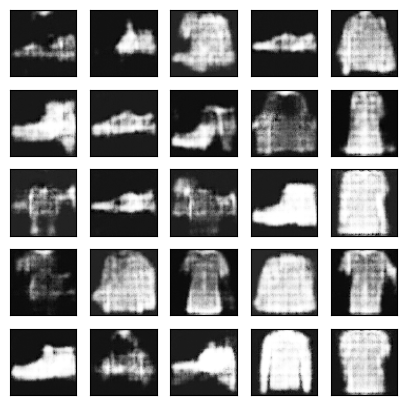

Epoch 2 - loss_d: 0.797, loss_g: 2.225


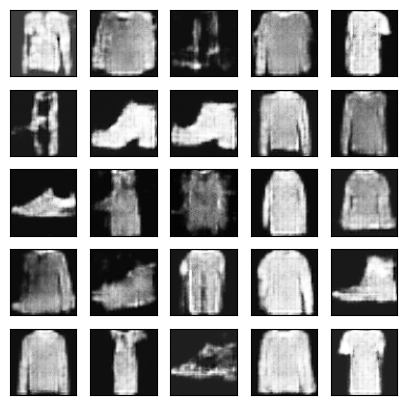

Epoch 3 - loss_d: 0.787, loss_g: 2.421


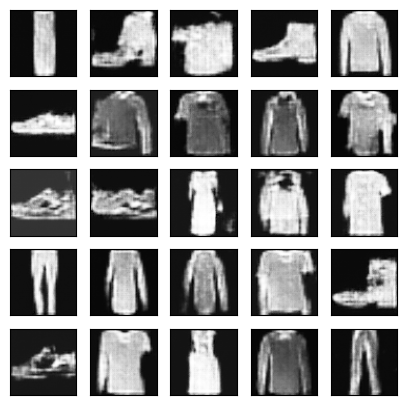

Epoch 4 - loss_d: 0.686, loss_g: 2.663


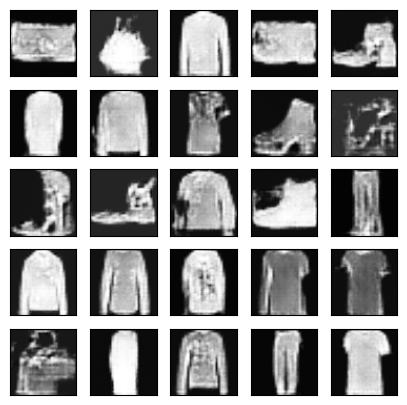

Epoch 5 - loss_d: 0.620, loss_g: 2.702


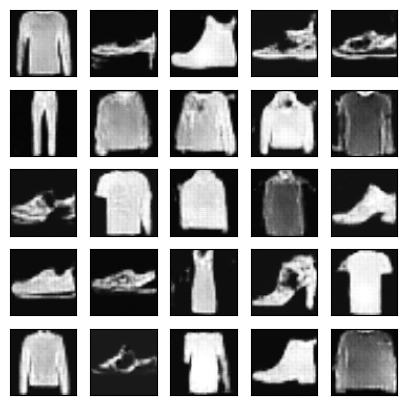

Epoch 6 - loss_d: 0.526, loss_g: 2.924


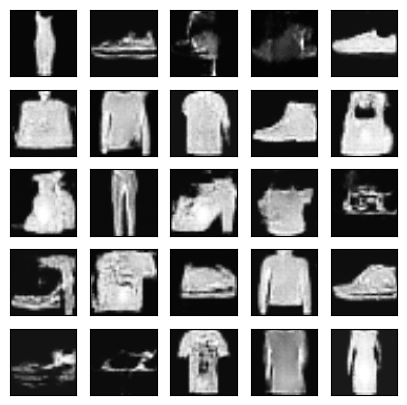

Epoch 7 - loss_d: 0.479, loss_g: 3.193


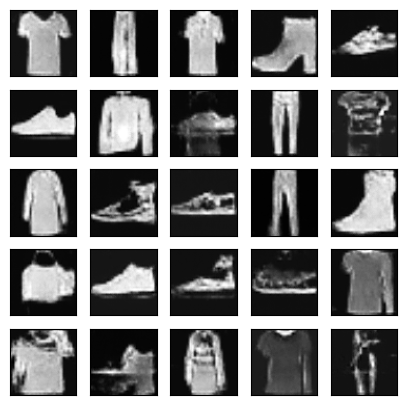

Epoch 8 - loss_d: 0.428, loss_g: 3.458


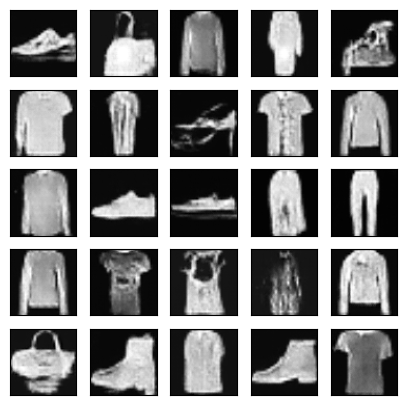

Epoch 9 - loss_d: 0.392, loss_g: 3.590


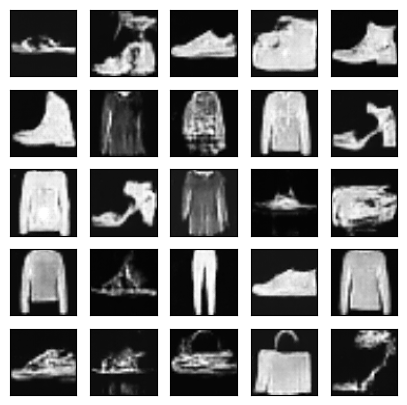

Epoch 10 - loss_d: 0.321, loss_g: 3.871


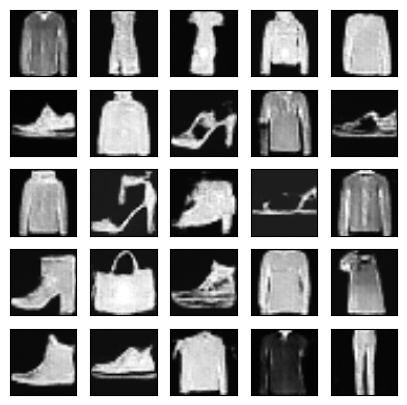

Epoch 11 - loss_d: 0.383, loss_g: 4.015


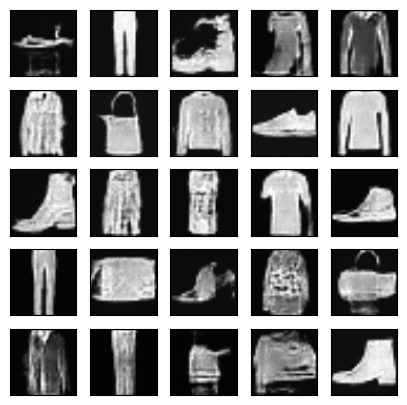

Epoch 12 - loss_d: 0.330, loss_g: 4.103


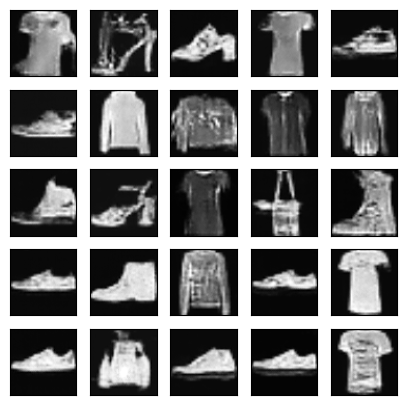

Epoch 13 - loss_d: 0.267, loss_g: 4.310


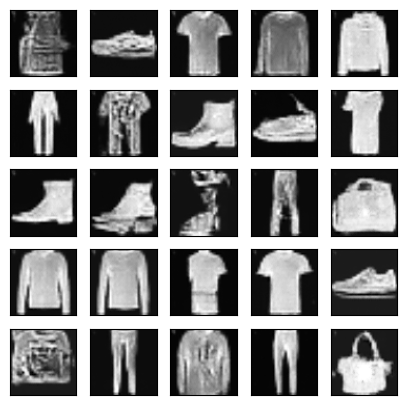

Epoch 14 - loss_d: 0.361, loss_g: 4.045


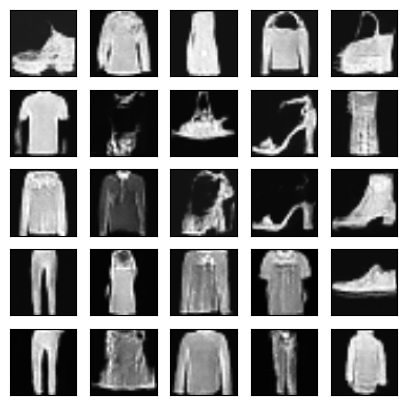

Epoch 15 - loss_d: 0.244, loss_g: 4.509


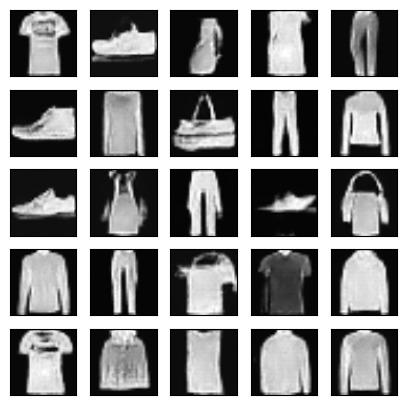

In [ ]:
run_dc()

## WGAN result

Streaming output truncated to the last 5000 lines.
GP: 0.06717541813850403
Gradient norm: 0.9975373148918152
G: -0.3954092264175415
Iteration 451
D: -0.19201698899269104
GP: 0.044466517865657806
Gradient norm: 0.9852945804595947
G: -0.43966734409332275
Iteration 501
D: -0.25504547357559204
GP: 0.031224355101585388
Gradient norm: 1.0038576126098633
G: -0.359260231256485
Iteration 551
D: -0.23744073510169983
GP: 0.041553907096385956
Gradient norm: 0.9912523031234741
G: -0.38616302609443665
Iteration 601
D: -0.20199614763259888
GP: 0.05956631898880005
Gradient norm: 1.0323396921157837
G: -0.39227813482284546
Iteration 651
D: -0.2131148874759674
GP: 0.08410472422838211
Gradient norm: 0.9894258975982666
G: -0.3727686405181885
Iteration 701
D: -0.2530673146247864
GP: 0.03453505411744118
Gradient norm: 1.0016112327575684
G: -0.37207549810409546
Iteration 751
D: -0.23113469779491425
GP: 0.06966377794742584
Gradient norm: 0.9947789311408997
G: -0.3717796802520752
Iteration 801
D: -0.18583396077

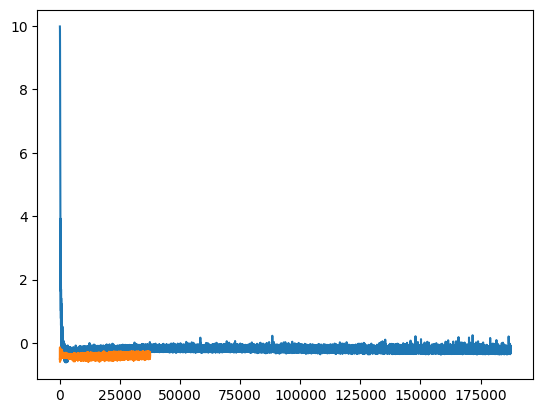

In [ ]:
run_wgp()

In [ ]:
gen_dc, _, gen_gp, _ = load_saved_models("/content/drive/MyDrive/HW3_DL/gen_dc_fashion_mnist_model.pt", "/content/drive/MyDrive/HW3_DL/dis_dc_fashion_mnist_model.pt",
                                         "/content/drive/MyDrive/HW3_DL/wp_gen_fashion_mnist_model.pt", "/content/drive/MyDrive/HW3_DL/wp_dis_fashion_mnist_model.pt"
                                         )

In [ ]:
gen_dc

generator_DC(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [ ]:
gen_gp

Generator_GP(
  (latent_to_features): Sequential(
    (0): Linear(in_features=100, out_features=2048, bias=True)
    (1): ReLU()
  )
  (features_to_image): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Sigmoid()
  )
)

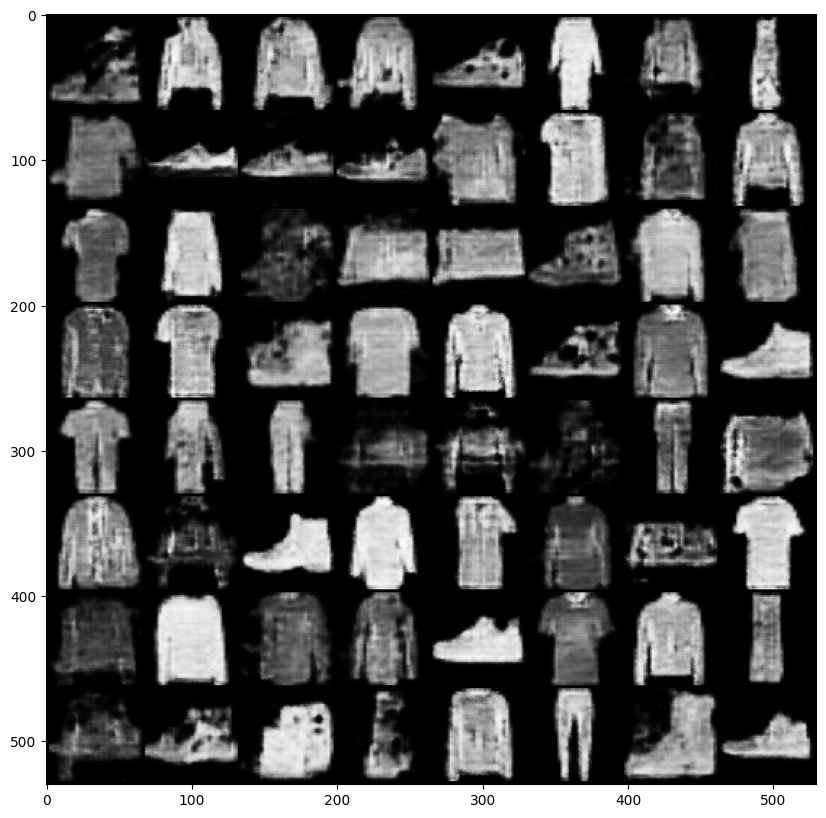

In [ ]:
im_b_gp = generate_im_batch_gp(gen_gp.cpu())